In [1]:
import sys
import os

# Enable MPS fallback to CPU
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from pathlib import Path
from importlib import reload
import warnings
# import random

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.append(str(Path(r'/Users/philip/Documents/github/arpesnet').resolve()))
import arpesnet as an

warnings.filterwarnings("ignore")

print("Python", sys.version)
print(f"Pytorch version: {torch.__version__} | CUDA enabled = {torch.cuda.is_available()}")

/opt/miniconda3/envs/nna11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/nna11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/miniconda3/envs/nna11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <CDA84A82-4B80-3170-BC5D-0E430A2552BE> /opt/miniconda3/envs/nna11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/miniconda3/envs/nna11/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are s

Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
Pytorch version: 2.5.0.dev20240624 | CUDA enabled = False


# Set random seed for reproducibility

In [2]:
torch.random.manual_seed(42)

# load data

### Set the path to the data directory
the `root` variable should be set to the path of the directory containing the data files. it should contain:
- test_datasets (directory containing the test images per material)
- train_datasets (directory containing the training images per material)
- test_imgs.pt

In [3]:
root = Path(r"/Users/philip/Documents/tmp_data/ARPESNet")
assert root.exists()

# setup data transformers

## image resizing and normalization
the `transform` variable should be set to the transformation to be applied to the images. it should contain:

In [4]:
normalizeAndResize = an.transform.Compose(
    [
        an.transform.Resize((256, 256)),
        an.transform.NormalizeMinMax(0, 100),
    ]
)

## possionian noise simulation

In [5]:
N = 100_000 # number of counts in the Poisson noise
setExposure = an.transform.SetRandomPoissonExposure(N)

# Load test images
for visual inspection

In [6]:
test_imgs = torch.load(root/"test_imgs.pt")
test_imgs = torch.stack([normalizeAndResize(s) for s in test_imgs])
test_imgs_noisy = torch.stack([setExposure(s) for s in test_imgs])

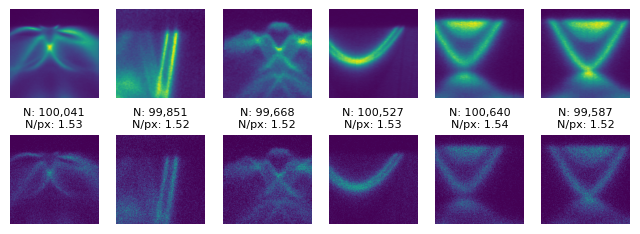

In [7]:
fig, ax = plt.subplots(2, len(test_imgs), figsize=(8, 3))
for i in range(len(test_imgs)):
    ax[0, i].imshow(test_imgs[i], cmap="viridis", origin="lower")
    ax[1, i].imshow(test_imgs_noisy[i], cmap="viridis", origin="lower")
    counts = test_imgs_noisy[i].sum()
    counts_per_pixel = counts / np.prod(test_imgs[i].shape)
    ax[1, i].set_title(f"N: {counts:,.0f}\nN/px: {counts_per_pixel:.2f}", fontsize=8)
    ax[0, i].axis("off")
    ax[1, i].axis("off")

# load training dataset

In [8]:
all_files = list((root/"train_data").glob("*.pt"))
train_data = torch.stack([normalizeAndResize(torch.load(f)) for f in tqdm(all_files)]).view(-1, 256, 256)
print(f"loaded {len(train_data):,.0f} training images with shape {train_data.shape[1:]}")

  0%|          | 0/28 [00:00<?, ?it/s]

loaded 14,000 training images with shape torch.Size([256, 256])


# setup training configuration

In [9]:
config = an.load_config(Path(an.__file__).parent.parent / "config.yml")
input_shape = [256,256]
norm = [0,100]
config["model"]["aenc"] = "arpesnet"
config["model"]["kwargs"] = dict(
    kernel_size = 11,
    kernel_decay = 2,
    # slope = 0.01, # 002821504416348863,
    n_layers = 1,
    start_channels = 4,
    max_channels = 32,
    n_blocks = 6,
    input_shape = input_shape,
    relu="PReLU",
    relu_kwargs=dict(num_parameters=1, init=0.25)
)
config["model"]["input_shape"] = input_shape

config['preprocessing']['Resize'] = input_shape
config['preprocessing']['NormalizeMinMax'] = norm

config['training_augmentations']["NormalizeMinMax"] = norm
config['training_augmentations']["RandomResizedCrop"]["size"] = input_shape

config["validation_augmentations"]["NormalizeMinMax"] = norm
config["validation_augmentations"]["Resize"] = input_shape

config["noise_augmentations"]["NormalizeMinMax"] = norm
config["noise_augmentations"]["SetRandomPoissonExposure"] = [50_000,100_000_000]

config["loss"]["criteria"] = ["mse"]

config["optimizer"]["name"] = "Adam"
config["optimizer"]["lr"] = 0.001

config["train"]["batch_size"] = 32
config["train"]["denoiser"] = False
config["train"]["shuffle"] = True
config["train"]["drop_last"] = True

In [10]:
trainer = an.ModelTrainer(config, verbose="full", train_dataset=train_data)
trainer.describe_model()

MODEL: ARPESNet
Parameters: 40,710 encoder | 40,679 decoder | total: 81,389
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(4, 8, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(8, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): PReLU(num_parameters=1)
  )
)
Decoder(
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), st

In [11]:
trainer.train(
    n_epochs=2,
    milestones=[2, 4, 6],
    milestone_every=10,
    save_dir="./",
    plot=True,
    save=True,
    test_imgs=test_imgs_noisy,
)
# trainer.plot_losses()
# trainer.plot_reconstruction(imgs_256, samples=10)


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2

# test visualize and evaluate model

## load test data

In [12]:
all_test_files = list((root/"test_data").glob("*.pt"))
test_data = torch.stack([normalizeAndResize(torch.load(f)) for f in tqdm(all_test_files[:10])]).view(-1, 256, 256)
test_data = test_data[::10]
print(f"loaded {len(test_data):,.0f} test images with shape {test_data.shape[1:]}")

  0%|          | 0/10 [00:00<?, ?it/s]

loaded 500 test images with shape torch.Size([256, 256])


## clean data

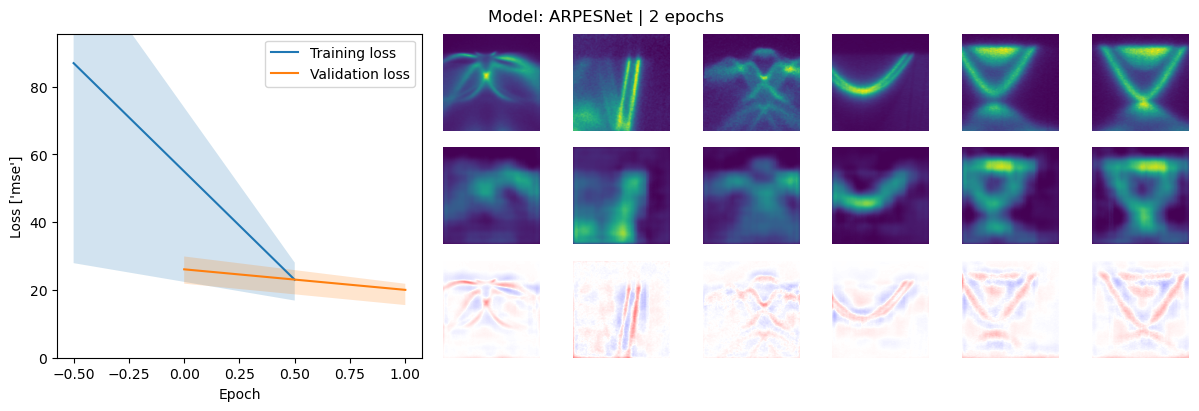

In [13]:
trainer.plot_loss_and_reconstruction(test_imgs)

In [14]:
trainer.test_model(test_data, metrics=['mse','psnr']).mean()

mse     31.117919
psnr    25.795360
dtype: float64

## noisy data

In [15]:
test_data_noisy = torch.stack([setExposure(s) for s in test_data])

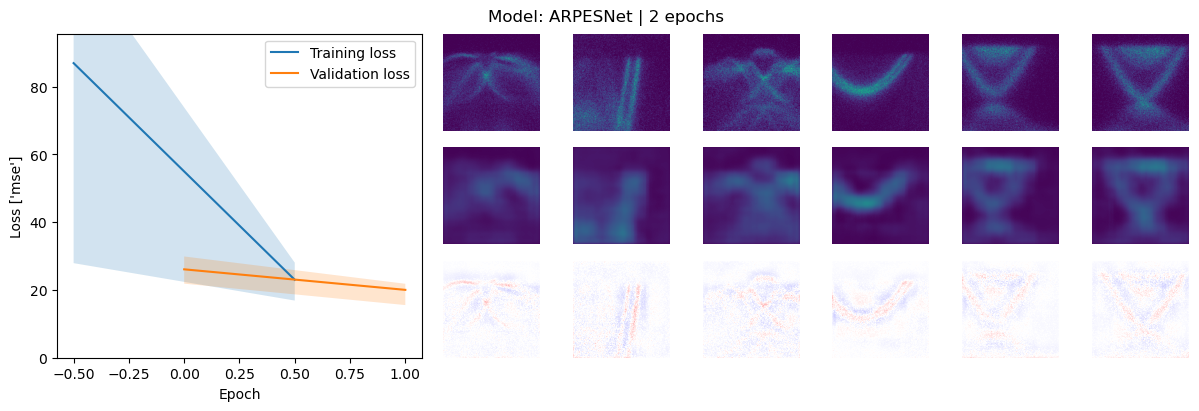

In [16]:
trainer.plot_loss_and_reconstruction(test_imgs_noisy)

In [17]:
trainer.test_model(test_data_noisy, metrics=['mse','psnr']).mean()

mse     83.145252
psnr    21.389153
dtype: float64